In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from load_dataset import load_dataset

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2023-01-18 22:03:01.927650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 22:03:02.145931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-18 22:03:02.145948: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 22:03:03.021738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

In [57]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation="sigmoid", padding='same'),
      layers.Lambda(lambda x: np.uint8(x*255))
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [54]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [40]:
np.random.seed(256)
path_to_dataset = Path("../SIDD_Small_sliced/Data/")
TRAIN_PAIRS_TO_LOAD = 1000
TEST_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
VAL_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
train_x, train_y, test_x, test_y, val_x, val_y = load_dataset(str(path_to_dataset), TRAIN_PAIRS_TO_LOAD, TEST_PAIRS_TO_LOAD, VAL_PAIRS_TO_LOAD)

In [55]:
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=2)

In [58]:
# think about callbacks/early stopping
# learn how to plot training history
history = autoencoder.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10
32/32 [==============================] - 36s 1s/step - loss: 5541.6284 - val_loss: 2466.5820 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 32s 1s/step - loss: 2155.9966 - val_loss: 1508.3186 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 34s 1s/step - loss: 1480.2393 - val_loss: 1231.8035 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 1289.1595 - val_loss: 906.7753 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 34s 1s/step - loss: 1140.2250 - val_loss: 852.1777 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 33s 1s/step - loss: 1058.9731 - val_loss: 781.6362 - lr: 0.0010
Epoch 7/10
32/32 [==============================] - 34s 1s/step - loss: 978.7521 - val_loss: 695.0060 - lr: 0.0010
Epoch 8/10
32/32 [==============================] - 34s 1s/step - loss: 916.9579 - val_loss: 661.2458 - lr: 0.0010
Epoch 9/10
32/32 [==============================] - 34s 1s/step - loss:

In [59]:
autoencoder.encoder.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 8)         1160      
                                                                 
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


In [66]:
encoded_imgs = autoencoder.encoder(test_x).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs = decoded_imgs.astype(np.uint8)

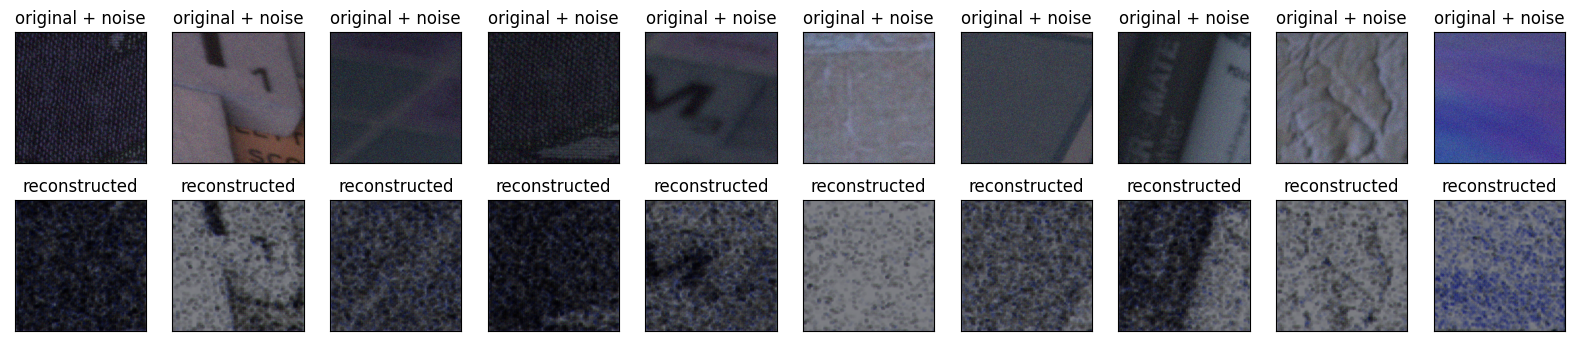

In [67]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(test_x[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
